In [1]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from keras.layers.convolutional import  MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import seaborn as sns
import cv2
import random
import glob
import keras
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

### Load Data and Explore Data

In [2]:
path_data = './class_cloud/'

In [3]:
class_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

[1, 380, 127, 119, 83, 91, 83, 305, 25]
max is  380 
min is  1


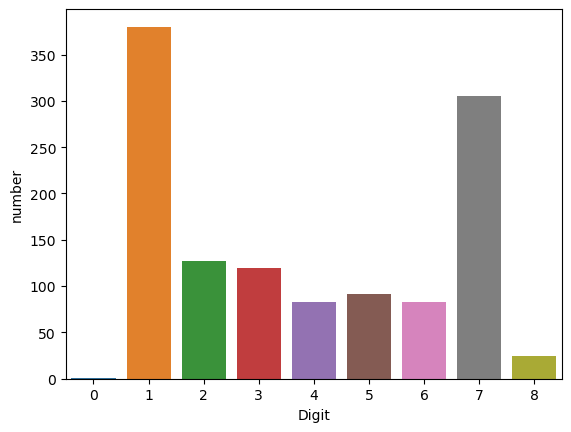

In [4]:
count=[]
for number in class_name :
    count.append(len(os.listdir(path_data+number)))
print(count)

df = pd.DataFrame({'Digit':class_name, 'number':count})
sns.barplot(data=df,x='Digit', y='number')

print('max is ',max(count),'\nmin is ',min(count))

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  #tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.15),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="wrap"),
  tf.keras.layers.RandomContrast(factor=0.2),
])

In [6]:
tf.get_logger().setLevel('ERROR')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


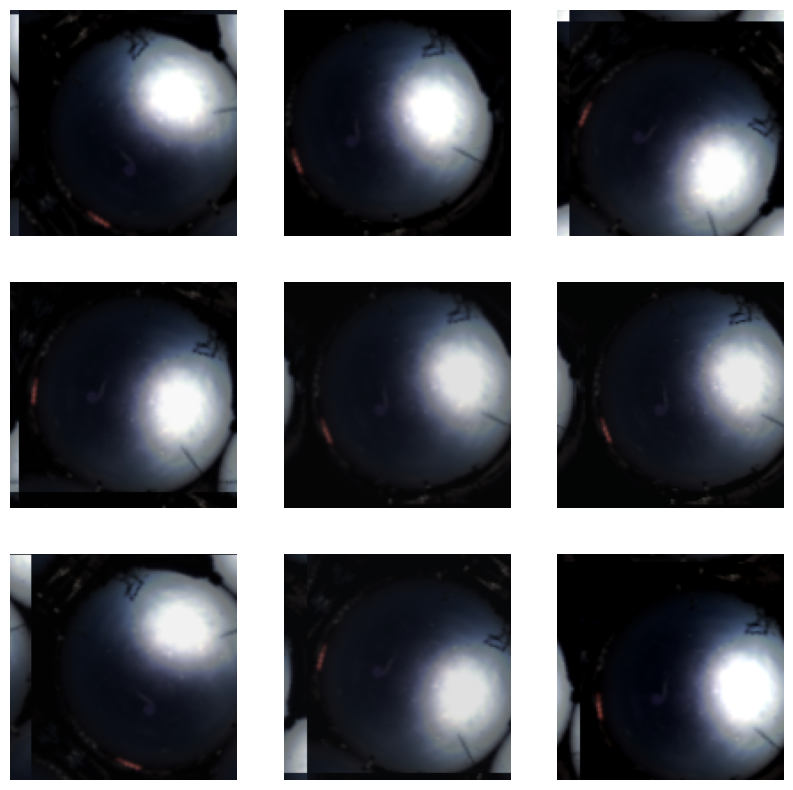

In [7]:
plt.figure(figsize=(10, 10))
path_img='./class_cloud_crop/{}'.format(random.choice(os.listdir('./class_cloud_crop')))
file_img = random.choice(os.listdir(path_img))
img = tf.keras.utils.load_img(path_img+'/'+file_img)
img_array = tf.keras.utils.img_to_array(img)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(img_array, 0))
    img=(augmented_image[0])
    # tf.keras.utils.save_img('test.png',augmented_image[0])
    plt.imshow(img)
    plt.axis('off')

In [8]:
1.5*max(count)

570.0

[420, 610, 485, 445, 431, 487, 431, 460, 425]
max is  610 
min is  420


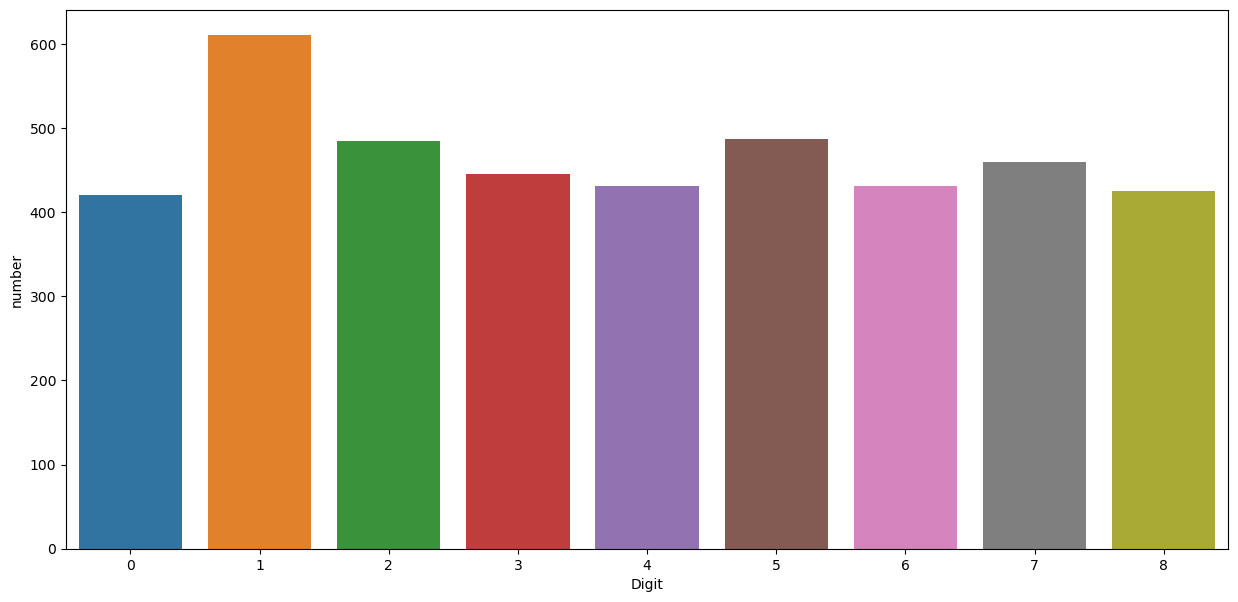

In [9]:
path_train_clean = './class_cloud_crop/'
count=[]
plt.figure(figsize=(15, 7))
for number in class_name :
    count.append(len(os.listdir(path_train_clean+number)))
print(count)

df = pd.DataFrame({'Digit':class_name, 'number':count})
sns.barplot(data=df,x='Digit', y='number')

print('max is ',max(count),'\nmin is ',min(count))

### Train Test Split

In [10]:
import pathlib
datadir = "./class_cloud_crop" #path ของ dataset
data = pathlib.Path(datadir)
batch_size = 16
img_height = 128
img_width = 128
IMG_SIZE = (128, 128)
#Train #sแบ่งข้อมูล เพื่อ training 80% และ validate 20% 
train = tf.keras.preprocessing.image_dataset_from_directory(data,validation_split=0.2,subset='training',seed=555,image_size=(img_height, img_width),batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(data,validation_split=0.2,subset='validation',seed=555,image_size=(img_height, img_width),batch_size=batch_size)


Found 4194 files belonging to 9 classes.
Using 3356 files for training.
Found 4194 files belonging to 9 classes.
Using 838 files for validation.


['0', '1', '2', '3', '4', '5', '6', '7', '8']


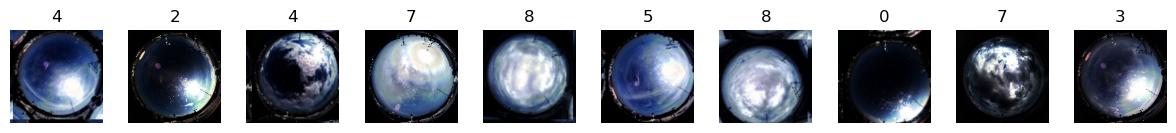

In [11]:
class_names = train.class_names
print(class_names)
plt.figure(figsize=(15, 7))
for images, labels in train.take(1):
    for i in range(10):
        ax = plt.subplot(5, 10, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)

In [17]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.BatchNormalization(),
layers.Conv2D(32, 3, padding='same', activation='relu'), 
layers.BatchNormalization(),
layers.Conv2D(32, 3,strides=2, padding='same', activation='relu'), 
layers.BatchNormalization(),    
layers.Dropout(0.4),      
    

layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.BatchNormalization(),
layers.Conv2D(64, 3, padding='same', activation='relu'), 
layers.BatchNormalization(),
layers.Conv2D(64, 3,strides=2, padding='same', activation='relu'), 
layers.BatchNormalization(),    
layers.Dropout(0.4),  
    
    
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.BatchNormalization(), 
layers.Dropout(0.4),    
layers.Dense(9, activation='softmax'),    
])

In [18]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)       

In [19]:
base_learning_rate = 0.01 #0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-6)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [21]:
initial_epochs = 100
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=val,
                    callbacks=[reduce_lr,callback])

Epoch 1/100
210/210 [==============================] - 26s 99ms/step - loss: 1.7016 - accuracy: 0.4073 - val_loss: 3.6162 - val_accuracy: 0.2673 - lr: 0.0100
Epoch 2/100
210/210 [==============================] - 19s 91ms/step - loss: 1.3933 - accuracy: 0.4821 - val_loss: 1.3724 - val_accuracy: 0.4690 - lr: 0.0100
Epoch 3/100
210/210 [==============================] - 20s 92ms/step - loss: 1.3074 - accuracy: 0.5122 - val_loss: 2.9086 - val_accuracy: 0.2971 - lr: 0.0100
Epoch 4/100
210/210 [==============================] - 20s 95ms/step - loss: 1.4420 - accuracy: 0.4574 - val_loss: 1.6519 - val_accuracy: 0.4415 - lr: 0.0100
Epoch 5/100
210/210 [==============================] - 21s 97ms/step - loss: 1.2863 - accuracy: 0.5119 - val_loss: 1.4266 - val_accuracy: 0.4630 - lr: 0.0100
Epoch 6/100
210/210 [==============================] - 19s 91ms/step - loss: 1.1633 - accuracy: 0.5697 - val_loss: 1.2183 - val_accuracy: 0.5334 - lr: 1.0000e-03
Epoch 7/100
210/210 [===========================

In [22]:
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

Last train accuracy: 0.7932062149047852
Last validation accuracy: 0.560859203338623


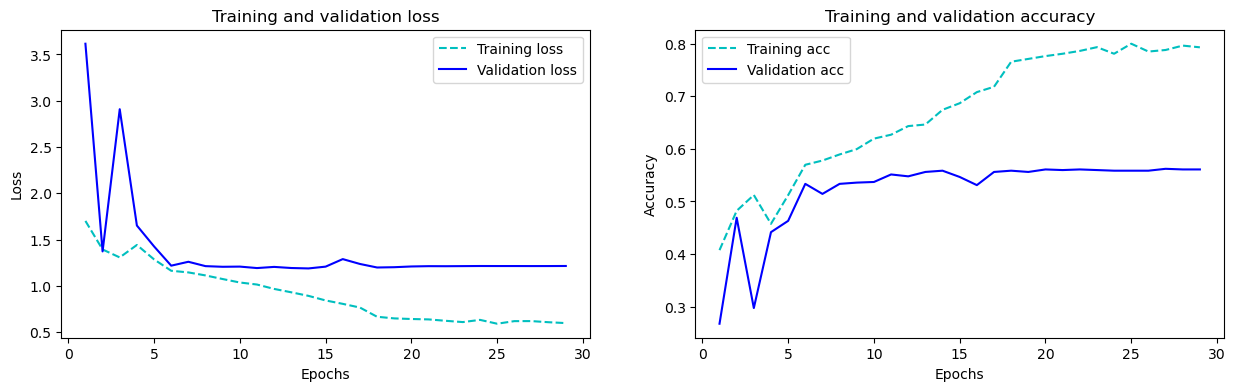

In [23]:
show_result(history)

In [30]:
loss0, accuracy0 = model.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

53/53 [==============================] - 2s 24ms/step - loss: 1.2149 - accuracy: 0.5609
initial loss: 1.21
initial accuracy: 0.56
